<a href="https://colab.research.google.com/github/xpdlaldam/nlp/blob/master/Hugging%20Face/audio_analysis/import_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
os.getcwd()

'/content'

In [5]:
os.chdir("drive/MyDrive/Colab Notebooks/Data/Audio")
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Data/Audio'

In [6]:
curr_dir_files = os.listdir()
curr_dir_files[0]

'wef_02484_00003859772.wav'

# 1. Three Ways to Read WAV Files

## Method 1: scipy.io.wavfile

In [ ]:
from scipy.io import wavfile

In [ ]:
sample_rate, data = wavfile.read(curr_dir_files[0])

print(f"Sample rate: {sample_rate} Hz")
print(f"Data shape: {data.shape}")

Sample rate: 48000 Hz
Data shape: (262144,)


## Method 2: librosa (best for audio analysis)

In [9]:
import librosa

In [11]:
audio, sample_rate = librosa.load(curr_dir_files[0], sr=None)

print(f"Sample rate: {sample_rate} Hz")
print(f"Audio shape: {audio.shape}")

Sample rate: 48000 Hz
Audio shape: (262144,)


## Method 3: wave module (low-level handling)

In [13]:
import wave
import numpy as np

with wave.open(curr_dir_files[0], "rb") as wav_file:
    sample_rate = wav_file.getframerate()
    n_frames = wav_file.getnframes()
    audio_data = wav_file.readframes(n_frames)
    audio_np = np.frombuffer(audio_data, dtype=np.int16)

print(f"Sample rate: {sample_rate} Hz")
print(f"Number of frames: {n_frames}")
print(f"Audio length: {len(audio_np)} samples")

Sample rate: 48000 Hz
Number of frames: 262144
Audio length: 262144 samples


# 2. Play Audio

## Method 1: IPython.display.Audio (best for Jupyter Notebooks)

In [ ]:
## only works in Jupyter or IPython
from IPython.display import Audio

In [ ]:
Audio(curr_dir_files[0])

## Method 2: pydub + simpleaudio (non-blocking and more control)

In [8]:
## Doesn't work in Jupyter
from pydub import AudioSegment
from pydub.playback import play

In [10]:
audio_0 = AudioSegment.from_wav(curr_dir_files[0])
play(audio_0)

# 3. Plot Waveform

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [12]:
# Load the audio file
# audio, sample_rate = librosa.load(curr_dir_files[0], sr=None) # sr=None preserves original sampling rate
audio.shape # Mono; Stereo shape is (2, num_samples)

(262144,)

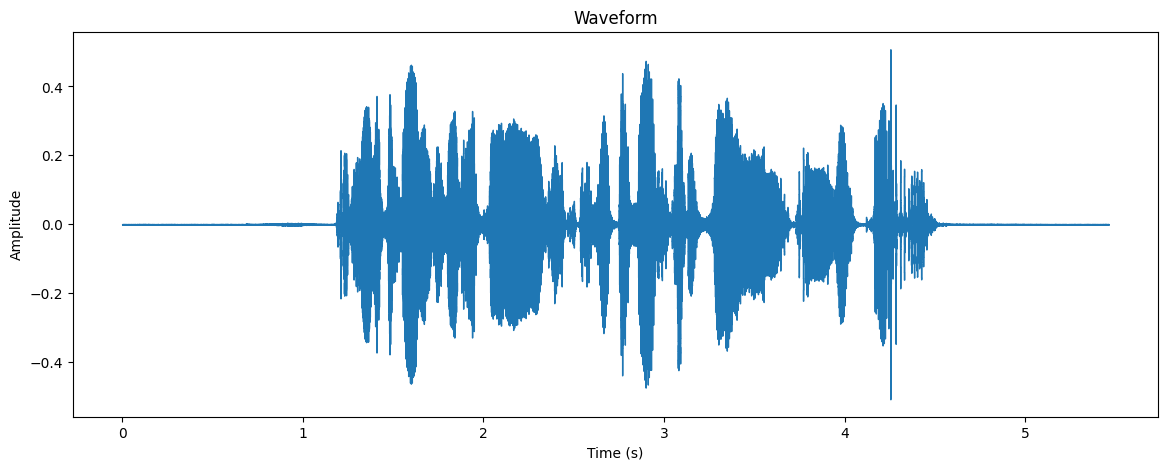

In [11]:
# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sample_rate)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()